# Heritability estimate on subtype from RELATIONAL activation maps

##### Subtype:
- Niak preprocessed RELATIONAL task (new scrub method)
- 5 subtype
- **FD_scrubbed_mean regressed out befor building subtypes**

##### Heritability:
- Regress "FD_scrubbed_mean" "Age_in_Yrs" "Gender" as covariate


## Build Pheno file

### Merge behavioral variables with subtypes weights

In [1]:
# Import pandas
import os
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [59]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set_style("whitegrid")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [4]:
# Set up the paths 
path_root = '/media/yassine/data_disk/Drive/HCP2/'
#path_root = "/home/yassinebha/Drive/HCP/"
subt_path = os.path.join(path_root,"subtypes_scores/26-10-2016/subtype_5_spm_RELATIONAL_18-Oct-2017/")
net_path = os.path.join(path_root,"subtypes_scores/26-10-2016/subtype_5_spm_RELATIONAL_18-Oct-2017/networks/")
out_path = os.path.join(path_root,"Solar_heritability/HCP_subtype/")

In [5]:
nb_sbt = natural_keys(subt_path)[9]
# task name
task_name = natural_keys(subt_path)[10][5:-1].lower()

In [6]:
task_name

'relational'

In [7]:
# Set up files name
sbt_name_pattern = "sbt_weights_net_{}.csv"
pheno_path = os.path.join(path_root,"subtypes_scores/26-10-2016/pheno/hcp_pheno_{}_raw.csv".format(task_name))
solar_script = 'fcd_solar_h2r_test.sh'
pheno_save = 'solar_RELATIONAL_spm_pheno.csv'.format(task_name)
pedig_save = 'solar_RELATIONAL_spm_pedigre.csv'.format(task_name)
solar_out = 'subtype_5_{}_{}'.format(task_name,time.strftime("%d-%m-%Y"))
h2r_out_file = 'h2r_solar_{}_spm_{}.csv'
## Solar covariates
solar_cov = '    cov FD_scrubbed_mean Gender'

In [8]:
# List of network names
list_trial = os.listdir(net_path)
list_trial

['match', 'relation', 'contrast_relation_vs_match']

In [9]:
# Loop over each network and build weight file
for index, trial_name in enumerate(list_trial):
    file_path = os.path.join(net_path, trial_name, sbt_name_pattern.format(trial_name))
    if not os.path.exists(file_path):
        print("Hello, {} does not exist".format(file_path))
    
    tmp_weights = pd.read_csv(file_path)
    # Rename first column
    tmp_weights.rename(columns={" ":"Subject"}, inplace=True)
    tmp_weights.Subject = tmp_weights.Subject.str.strip(" ")
    
    rename_dict = dict()
    for colname in tmp_weights.columns:
        if colname == "Subject":
            continue
        else:
            new_name = "{}_{}".format(trial_name, colname)
            # Get rid of trailing whitespace
            new_name = new_name.strip(" ")
            rename_dict[colname] = new_name

    tmp_weights.rename(columns=rename_dict, inplace=True)
    
    if index==0:
        dataframe = tmp_weights
    else:
        dataframe = pd.merge(dataframe, tmp_weights, on="Subject", how="inner")

In [10]:
dataframe.head()

,Subject,match_sub1,match_sub2,match_sub3,match_sub4,match_sub5,relation_sub1,relation_sub2,relation_sub3,relation_sub4,relation_sub5,contrast_relation_vs_match_sub1,contrast_relation_vs_match_sub2,contrast_relation_vs_match_sub3,contrast_relation_vs_match_sub4,contrast_relation_vs_match_sub5
0,HCP100206,-0.229,0.219,-0.148,-0.105,0.234,0.268,0.313,-0.199,0.263,-0.318,-0.090,0.085,-0.041,-0.085,0.141
1,HCP100307,0.737,-0.722,0.357,0.410,-0.714,-0.259,-0.727,0.296,-0.696,0.734,0.237,0.104,-0.205,-0.050,-0.181
2,HCP100408,-0.488,0.503,-0.347,-0.236,0.471,0.038,0.641,-0.208,0.655,-0.638,-0.226,-0.286,0.366,0.141,0.122
3,HCP100610,-0.119,0.126,-0.048,-0.120,0.136,-0.220,0.261,-0.109,0.379,-0.262,-0.229,-0.504,0.424,0.446,0.027
4,HCP101006,-0.267,0.253,-0.158,-0.143,0.285,0.088,0.527,-0.241,0.518,-0.518,-0.184,-0.061,0.125,0.036,0.154


In [11]:
dataframe.Subject.describe()

count           764
unique          764
top       HCP308129
freq              1
Name: Subject, dtype: object

In [12]:
# Load pheno file
file_weight = dataframe
file_pheno = pd.read_csv(pheno_path)

In [13]:
file_pheno.head()

,Unnamed: 0,FD_RL,FD_scrubbed_RL,FD_LR,FD_scrubbed_LR,FD_scrubbed_mean,FD_mean,Subject,Age_in_Yrs,Gender,...,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
0,HCP100206,0.098646,0.091387,0.118289,0.118289,0.104838,0.108467,HCP100206,27.0,1.0,...,-0.344595,1.283574,0.052662,1.436342,0.706008,-0.510366,1.975280,1.294323,-0.025888,-0.203825
1,HCP100307,0.108372,0.108372,0.098514,0.098514,0.103443,0.103443,HCP100307,27.0,2.0,...,-0.639736,0.522789,-0.952467,-0.713226,-0.559144,-0.140952,-0.703027,0.229112,0.097581,-0.444702
2,HCP100408,0.113633,0.113633,0.145309,0.145309,0.129471,0.129471,HCP100408,33.0,1.0,...,1.173656,0.092160,-0.521888,-0.034026,-0.109229,0.221359,-0.589268,0.357483,-0.039443,0.095913
3,HCP100610,0.184109,0.184109,0.170573,0.160610,0.172360,0.177341,HCP100610,27.0,1.0,...,0.891096,-0.361182,-0.881930,-0.386394,-0.575076,-0.197974,0.203063,0.618868,0.491618,1.343114
4,HCP101006,0.146478,0.146478,0.152041,0.148402,0.147440,0.149260,HCP101006,35.0,2.0,...,0.608381,0.037740,0.055531,-0.883482,-0.383174,-0.309221,-0.753780,-1.183212,0.031989,-0.494022


In [14]:
file_pheno.Subject.describe()

count           797
unique          797
top       HCP567961
freq              1
Name: Subject, dtype: object

In [15]:
# Select a subset of variable
file_pheno_subset = file_pheno[["Subject","Age_in_Yrs","Gender","BMI","FD_mean","FD_scrubbed_mean"]]
file_pheno_subset.head()

,Subject,Age_in_Yrs,Gender,BMI,FD_mean,FD_scrubbed_mean
0,HCP100206,27.0,1.0,26.64,0.108467,0.104838
1,HCP100307,27.0,2.0,22.96,0.103443,0.103443
2,HCP100408,33.0,1.0,27.75,0.129471,0.129471
3,HCP100610,27.0,1.0,36.91,0.177341,0.172360
4,HCP101006,35.0,2.0,30.27,0.149260,0.147440


In [16]:
# Replace gender M=1 and F=2
#file_pheno_subset.Gender.replace({'M':1,'F':2}, inplace=True)
#file_pheno_subset.head()

In [17]:
file_pheno_subset[["Subject"]].describe()

,Subject
count,797
unique,797
top,HCP567961
freq,1


In [18]:
file_weight[["Subject"]].describe()

,Subject
count,764
unique,764
top,HCP308129
freq,1


In [19]:
# Merge weight with subset of pheno variables
merged_weight_pheno = pd.merge(file_weight, file_pheno_subset, on='Subject', how='left')
# Replace 'Subject' by 'ID'
merged_weight_pheno.rename(columns={'Subject':'ID'},inplace=True)
merged_weight_pheno.head()

,ID,match_sub1,match_sub2,match_sub3,match_sub4,match_sub5,relation_sub1,relation_sub2,relation_sub3,relation_sub4,...,contrast_relation_vs_match_sub1,contrast_relation_vs_match_sub2,contrast_relation_vs_match_sub3,contrast_relation_vs_match_sub4,contrast_relation_vs_match_sub5,Age_in_Yrs,Gender,BMI,FD_mean,FD_scrubbed_mean
0,HCP100206,-0.229,0.219,-0.148,-0.105,0.234,0.268,0.313,-0.199,0.263,...,-0.090,0.085,-0.041,-0.085,0.141,27.0,1.0,26.64,0.108467,0.104838
1,HCP100307,0.737,-0.722,0.357,0.410,-0.714,-0.259,-0.727,0.296,-0.696,...,0.237,0.104,-0.205,-0.050,-0.181,27.0,2.0,22.96,0.103443,0.103443
2,HCP100408,-0.488,0.503,-0.347,-0.236,0.471,0.038,0.641,-0.208,0.655,...,-0.226,-0.286,0.366,0.141,0.122,33.0,1.0,27.75,0.129471,0.129471
3,HCP100610,-0.119,0.126,-0.048,-0.120,0.136,-0.220,0.261,-0.109,0.379,...,-0.229,-0.504,0.424,0.446,0.027,27.0,1.0,36.91,0.177341,0.172360
4,HCP101006,-0.267,0.253,-0.158,-0.143,0.285,0.088,0.527,-0.241,0.518,...,-0.184,-0.061,0.125,0.036,0.154,35.0,2.0,30.27,0.149260,0.147440


In [20]:
merged_weight_pheno.ID.describe()

count           764
unique          764
top       HCP308129
freq              1
Name: ID, dtype: object

In [21]:
# Check if there is empty value in BMI
sum(merged_weight_pheno.BMI.isnull())

0

In [22]:
# Save the merged file
merged_weight_pheno.to_csv(os.path.join(out_path,pheno_save), index=False)

In [23]:
os.path.join(out_path,pheno_save)

'/media/yassine/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/solar_RELATIONAL_spm_pheno.csv'

## Build trait file

In [24]:
## build trait file
# Remove not neaded traits
list_trait = merged_weight_pheno.columns.tolist()
new_list = [trait for trait in list_trait if trait not in ['ID','Age_in_Yrs','Gender']]
new_list

['match_sub1',
 'match_sub2',
 'match_sub3',
 'match_sub4',
 'match_sub5',
 'relation_sub1',
 'relation_sub2',
 'relation_sub3',
 'relation_sub4',
 'relation_sub5',
 'contrast_relation_vs_match_sub1',
 'contrast_relation_vs_match_sub2',
 'contrast_relation_vs_match_sub3',
 'contrast_relation_vs_match_sub4',
 'contrast_relation_vs_match_sub5',
 'BMI',
 'FD_mean',
 'FD_scrubbed_mean']

In [25]:
# Save trait file
file_out = open(os.path.join(out_path,"trait_file"), 'w')
for item in new_list:
    file_out.write("%s\n" % item)
file_out.close()

## Build Pedigree file

In [26]:
# Select a subset of variable from pheno file
file_pheno_pedig = file_pheno[["Subject","Twin_Stat","Zygosity","Mother_ID","Gender"]]
file_pheno_pedig.head()

,Subject,Twin_Stat,Zygosity,Mother_ID,Gender
0,HCP100206,NotTwin,NotTwin,56037.0,1.0
1,HCP100307,Twin,NotMZ,51488.0,2.0
2,HCP100408,Twin,MZ,51730.0,1.0
3,HCP100610,Twin,NotMZ,52813.0,1.0
4,HCP101006,Twin,MZ,51283.0,2.0


In [27]:
file_pheno_pedig.Subject.describe()

count           797
unique          797
top       HCP567961
freq              1
Name: Subject, dtype: object

In [28]:
# Build pedigre : ID , mo, fo, hhID, mztwins,sex
mother_id = ["mo_{}".format(row.Mother_ID) for ind, row in file_pheno_pedig.iterrows()]
father_id = ["fa_{}".format(row.Mother_ID) for ind, row in file_pheno_pedig.iterrows()]
household_id = ["hh_{}".format(row.Mother_ID) for ind, row in file_pheno_pedig.iterrows()]
twin_id = ["pair_{}".format(row.Mother_ID) if row.Zygosity == "MZ" else "" for ind, row in file_pheno_pedig.iterrows()]

In [29]:
# write into new data frame
df_pedig = pd.DataFrame()
df_pedig["ID"] = file_pheno_pedig.Subject
df_pedig["fa"] = father_id
df_pedig["mo"] = mother_id
df_pedig["sex"] = file_pheno_pedig.Gender.astype(int)
df_pedig["mztwin"] = twin_id
df_pedig["hhID"] = household_id


print("head")
display(df_pedig.head())
print("tail")
display(df_pedig.tail())
df_pedig.count()

head


,ID,fa,mo,sex,mztwin,hhID
0,HCP100206,fa_56037.0,mo_56037.0,1,,hh_56037.0
1,HCP100307,fa_51488.0,mo_51488.0,2,,hh_51488.0
2,HCP100408,fa_51730.0,mo_51730.0,1,pair_51730.0,hh_51730.0
3,HCP100610,fa_52813.0,mo_52813.0,1,,hh_52813.0
4,HCP101006,fa_51283.0,mo_51283.0,2,pair_51283.0,hh_51283.0


tail


,ID,fa,mo,sex,mztwin,hhID
792,HCP992673,fa_56143.0,mo_56143.0,2,,hh_56143.0
793,HCP992774,fa_51345.0,mo_51345.0,1,,hh_51345.0
794,HCP993675,fa_55800.0,mo_55800.0,2,,hh_55800.0
795,HCP994273,fa_52364.0,mo_52364.0,1,,hh_52364.0
796,HCP996782,fa_51541.0,mo_51541.0,2,,hh_51541.0


ID        797
fa        797
mo        797
sex       797
mztwin    797
hhID      797
dtype: int64

In [30]:
# Look for MZ twins missing their co-twin
uniques = list(df_pedig.mztwin.unique())
uniques.pop(0)
twin_counts = [np.sum(df_pedig.mztwin==twin) for twin in uniques]
#for idx, twin in enumerate(uniques):
    #print("{} occurs {} times".format(twin, twin_counts[idx]))

In [31]:
# create a mask that will kepp only MZ twins missing their co-twin
singles = [True if np.sum(df_pedig.mztwin==row.mztwin)==1 else False for ind, row in df_pedig.iterrows()]

In [32]:
# Make a copy of the pedigre to avoid missing up with the original data
copy_df_pedig = df_pedig.copy()

In [33]:
# Select only MZ twins missing their co-twin
df_single_pedig = copy_df_pedig[singles]

# Add "M_" (for missing) to a the single MZ twins
for i, row in df_single_pedig.iterrows():
    df_single_pedig.set_value(i,"ID","M_{}".format(row.ID))
display(df_single_pedig.head())
df_single_pedig.count()

,ID,fa,mo,sex,mztwin,hhID
37,M_HCP110007,fa_54572.0,mo_54572.0,2,pair_54572.0,hh_54572.0
55,M_HCP114823,fa_52925.0,mo_52925.0,2,pair_52925.0,hh_52925.0
82,M_HCP122317,fa_51802.0,mo_51802.0,1,pair_51802.0,hh_51802.0
87,M_HCP123824,fa_56022.0,mo_56022.0,1,pair_56022.0,hh_56022.0
90,M_HCP124422,fa_51529.0,mo_51529.0,2,pair_51529.0,hh_51529.0


ID        43
fa        43
mo        43
sex       43
mztwin    43
hhID      43
dtype: int64

In [34]:
# Append pedgree with fake co-twin for the missing one
df_pedig_final = copy_df_pedig.append(df_single_pedig)
df_pedig_final.head()

,ID,fa,mo,sex,mztwin,hhID
0,HCP100206,fa_56037.0,mo_56037.0,1,,hh_56037.0
1,HCP100307,fa_51488.0,mo_51488.0,2,,hh_51488.0
2,HCP100408,fa_51730.0,mo_51730.0,1,pair_51730.0,hh_51730.0
3,HCP100610,fa_52813.0,mo_52813.0,1,,hh_52813.0
4,HCP101006,fa_51283.0,mo_51283.0,2,pair_51283.0,hh_51283.0


In [35]:
df_pedig_final.tail()

,ID,fa,mo,sex,mztwin,hhID
689,M_HCP769064,fa_52803.0,mo_52803.0,1,pair_52803.0,hh_52803.0
716,M_HCP835657,fa_52137.0,mo_52137.0,2,pair_52137.0,hh_52137.0
718,M_HCP837964,fa_52875.0,mo_52875.0,2,pair_52875.0,hh_52875.0
760,M_HCP904044,fa_51290.0,mo_51290.0,2,pair_51290.0,hh_51290.0
784,M_HCP972566,fa_56077.0,mo_56077.0,2,pair_56077.0,hh_56077.0


In [36]:
df_pedig_final.count()

ID        840
fa        840
mo        840
sex       840
mztwin    840
hhID      840
dtype: int64

In [37]:
# Save the pedigree file
df_pedig_final.to_csv(os.path.join(out_path,pedig_save), index=False)

## Run SOLAR heritability estimate 

In [38]:
%%bash -s "$out_path" "$solar_cov" "$solar_script" 
cd $1 #cd to out_path
#sufix=$(echo $2 | sed -e 's/ /_/g') # add a suffix of covariate
sed -i "104s/.*/$2/" $3 # feed the covariate to solar script
sed -i "52s~.*~$1phi2.gz~" $3 # put the right path for the simlink
sed -i "53s~.*~$1pedindex.out~" $3
sed -i "54s~.*~$1pedindex.cde~" $3
sed -i "55s~.*~$1se_univ_polygen.tcl~" $3

In [39]:
%%bash -s "$out_path" "$pedig_save"
cd $1
solar <<INTERNAL_SOLAR_SCRIPT  
load pedi $2
pedigree classes -full
INTERNAL_SOLAR_SCRIPT


SOLAR Eclipse version 8.1.1 (General), last updated on December 12, 2017
Copyright (c) 1995-2017 Texas Biomedical Research Institute
Enter help for help, exit to exit, doc to browse documentation.

Unloading current pedigree data ...
Loading pedigree data from the file solar_RELATIONAL_spm_pedigre.csv ...
::::::::::::::
mibdrel.tab
::::::::::::::

    NPairs  Relationship
  ========  ===========================================
      1568  Self
       117  Identical sib pair
      1680  Parent-offspring
       586  Siblings
       364  Unrelated



In [40]:
%%bash -s "$out_path" "$pheno_save" "$solar_out"
cd $1
#if [ ! -d $3 ]; then
#   mkdir $3
#fi
solar <<INTERNAL_SOLAR_SCRIPT 
load pheno $2
INTERNAL_SOLAR_SCRIPT
bash fcd_solar_h2r_test.sh trait_file $3 $1$2
for i in $3/Set-*; do bash $i/run_all.sh ; done


SOLAR Eclipse version 8.1.1 (General), last updated on December 12, 2017
Copyright (c) 1995-2017 Texas Biomedical Research Institute
Enter help for help, exit to exit, doc to browse documentation.

Creating output directories...
00017 : Set-17 : FD_scrubbed_mean                                                  
All done.


## Results

In [41]:
out_herit = pd.read_csv(os.path.join(out_path,solar_out,"se_out.out"),sep="\t",header=None)
out_herit_df =  pd.DataFrame()

data = pd.DataFrame({"Trait": out_herit[2],"H2r": out_herit[4],"P": out_herit[7],"CovVarianceExpl": out_herit[9]})
out_herit_df = data[["Trait","H2r","P","CovVarianceExpl"]].sort_values(['Trait'], ascending=[True]).reset_index(drop=True)
out_herit_df

,Trait,H2r,P,CovVarianceExpl
0,BMI_norm,0.596150,1.609180e-13,0.296816
1,FD_mean_norm,0.243918,1.196360e-02,0.850358
2,contrast_relation_vs_match_sub1_norm,0.097465,7.622840e-02,0.000103
3,contrast_relation_vs_match_sub2_norm,0.152053,2.540930e-02,0.001910
4,contrast_relation_vs_match_sub3_norm,0.142514,2.119550e-02,0.000619
5,contrast_relation_vs_match_sub4_norm,0.100051,1.037657e-01,0.000110
6,contrast_relation_vs_match_sub5_norm,0.086781,1.056090e-01,0.000263
7,match_sub1_norm,0.483234,3.688557e-14,-0.000043
8,match_sub2_norm,0.484474,3.813450e-14,-0.000057
9,match_sub3_norm,0.354013,3.000000e-07,0.010470


In [42]:
# remove unwanted Variables
out_herit_df_clean = out_herit_df[~out_herit_df['Trait'].str.strip().isin(['BMI_norm','FD_mean_norm','FD_scrubbed_mean_norm'])]

In [43]:
# FDR
from statsmodels.sandbox.stats import multicomp as smi
pcorr_vec = smi.multipletests(out_herit_df_clean['P'], alpha=0.05, method='fdr_bh')
out_herit_df_clean.insert(3,'FDR',pcorr_vec[1])
out_herit_df_clean.insert(4,'FDR_log10',-np.log10(pcorr_vec[1]))

In [44]:
out_herit_df_clean

,Trait,H2r,P,FDR,FDR_log10,CovVarianceExpl
2,contrast_relation_vs_match_sub1_norm,0.097465,7.622840e-02,8.795585e-02,1.055735,0.000103
3,contrast_relation_vs_match_sub2_norm,0.152053,2.540930e-02,3.176162e-02,1.498097,0.001910
4,contrast_relation_vs_match_sub3_norm,0.142514,2.119550e-02,2.890295e-02,1.539058,0.000619
5,contrast_relation_vs_match_sub4_norm,0.100051,1.037657e-01,1.056090e-01,0.976299,0.000110
6,contrast_relation_vs_match_sub5_norm,0.086781,1.056090e-01,1.056090e-01,0.976299,0.000263
7,match_sub1_norm,0.483234,3.688557e-14,8.171679e-14,13.087689,-0.000043
8,match_sub2_norm,0.484474,3.813450e-14,8.171679e-14,13.087689,-0.000057
9,match_sub3_norm,0.354013,3.000000e-07,4.500000e-07,6.346787,0.010470
10,match_sub4_norm,0.525551,5.417273e-17,2.708637e-16,15.567249,0.002827
11,match_sub5_norm,0.492009,9.739519e-15,2.921856e-14,13.534341,0.000043


In [45]:
# Loop over trait and create heritability table for radar plot
#drop_list = ['BMI','FD_mean','FD_scrubbed_mean','Handedness']
#list_new = [x for x in new_list if x not in drop_list ]

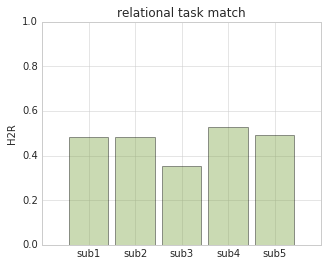

Subt,sub1,sub2,sub3,sub4,sub5
H2R,0.483234,0.484474,0.354013,0.525551,0.492009


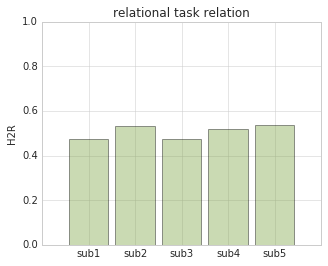

Subt,sub1,sub2,sub3,sub4,sub5
H2R,0.472168,0.533172,0.472334,0.519555,0.536545


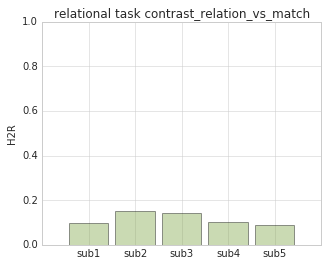

Subt,sub1,sub2,sub3,sub4,sub5
H2R,0.097465,0.152053,0.142514,0.100051,0.086781


In [65]:
## Loop over trait and create heritability table for radar plot
#list_trial = [xx.replace('-','_') for xx in list_trial]

list_sbt = ['sub1','sub2','sub3','sub4','sub5']
for trait_herit in list_trial:
    mask_df = [x[:-10] == trait_herit for x in out_herit_df_clean.Trait.str.strip()]
    out_herit_select = out_herit_df_clean[['Trait','H2r']][mask_df]
    # extract trial
    column_net = [' '.join(row['Trait'].split('_')[0:-2]) for ind,row in out_herit_select[['Trait']].iterrows()]
    out_herit_select.loc[:,'Trial'] = column_net
    # extract subtype
    column_subt = [row['Trait'].split('_')[-2].strip() for ind,row in out_herit_select[['Trait']].iterrows()]
    out_herit_select.loc[:,'Subt'] = column_subt
    out_herit_clean = out_herit_select[['Trial','Subt','H2r']]
    # Pivot table
    out_herit_final = out_herit_clean.pivot(index='Trial',columns='Subt',values='H2r')
    out_herit_final.index.name=None
    out_herit_final.rename(index={column_net[1]: 'H2R'},inplace= True)
    #put 0 for non for empty heritabity
    for ii in list_sbt:
        if ii not in out_herit_final.columns.get_values():
            out_herit_final.loc[:,ii]=0
    out_herit_final=out_herit_final[list_sbt]
    out_herit_final.to_csv(os.path.join(out_path,solar_out,h2r_out_file.format(task_name,trait_herit)))
    # H2R bar plot
    fig,ax = plt.subplots(figsize=(5, 4))
    y_pos = np.arange(len(out_herit_final.columns))
    ax.bar(y_pos,out_herit_final.ix['H2R'],color="#7ca343",alpha=0.4,align = 'center',width=0.85)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(list_sbt)
    ax.set_ylim(0,1)
    ax.set_ylabel('H2R')
    #ax.grid(False)
    plt.title('{} task {}'.format(task_name,trait_herit))
    plt.show()
    fig.savefig(os.path.join(subt_path,"{}_barplot_heritability.svg".format(trait_herit)))
    display(out_herit_final)

In [47]:
##### R section #########

In [48]:
# first on terminal install cairo : "sudo apt install libcairo2-dev"
# devtools::install_github("hadley/svglite")
# devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)
import warnings
warnings.filterwarnings('ignore')

In [49]:
%%R
library(ggradar)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

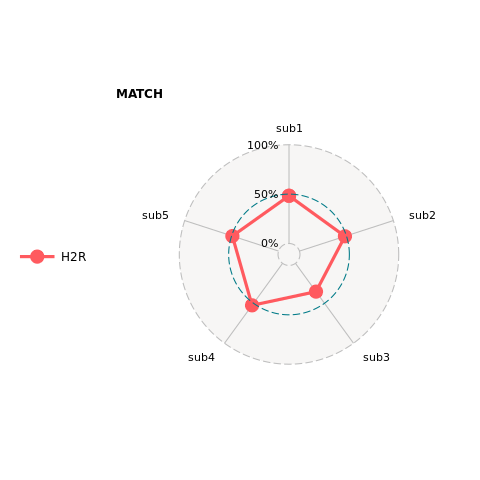

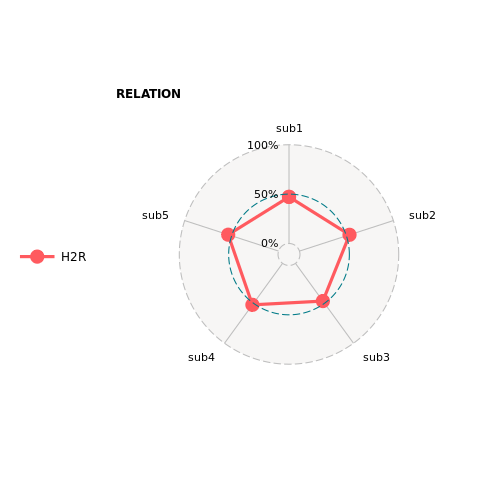

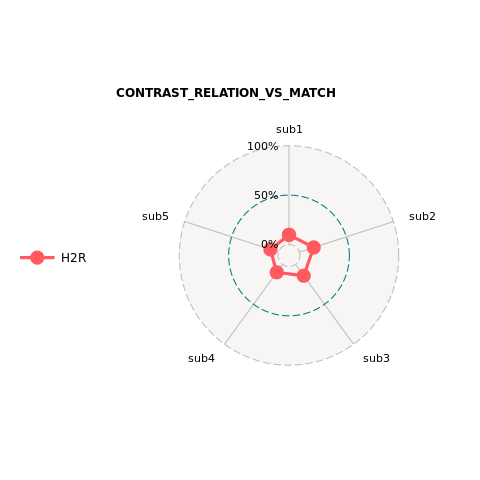

In [50]:
%%R -i out_path,solar_out,task_name,list_trial,path_root
for (ii in list_trial) {
    MyData <- read.csv(file=paste(out_path,solar_out,"/h2r_solar_",task_name,'_spm_',ii,'.csv',sep = ''))
    # plot radar 
    image=ggradar(MyData, grid.min = 0,
                  grid.mid = 0.5, 
                  grid.max = 1, 
                  axis.label.size = 4, 
                  grid.label.size = 5 ,
                  legend.text.size =5) +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' \n  ',toupper(ii),sep = ''))
    ggsave(file=paste(path_root,"subtypes_scores/26-10-2016/subtype_5_spm_RELATIONAL_18-Oct-2017/" ,ii,"_heritability.svg",sep = ''), plot=image, width=10, height=8)
    print(image)
     }